## A notebook containing an implementation of the GloVe algorithm and visualization of the semantic space



### Text processing

In [35]:
import re

def separate_sentences(file_path):
    with open(file_path, 'r+') as file:
        text = file.read()

        # Split text into sentences
        sentences = re.split(r'(?<=[.!?])\s+', text)

        # Move the file pointer to the beginning and truncate the file
        file.seek(0)
        file.truncate()

        # Write the modified text to the same file
        file.write('\n'.join(sentences))

# Example usage
file_path = '/Users/Thomas/Downloads/corpus_viking.txt'  # Replace with the actual path to your text file,since user usually not thomas

separate_sentences(file_path)



### Algorithm

In [63]:
import numpy as np
from collections import defaultdict


def build_cooccurrence_matrix(corpus, window_size):
    vocab = {}
    cooc_matrix = defaultdict(float)

    for sentence in corpus:
        words = sentence.strip().split()
        for i, word in enumerate(words):
            if word not in vocab:
                vocab[word] = len(vocab)

            for j in range(max(0, i - window_size), min(len(words), i + window_size + 1)):
                if i != j:
                    context_word = words[j]
                    if context_word not in vocab:
                        vocab[context_word] = len(vocab)

                    word_idx = vocab[word]
                    context_word_idx = vocab[context_word]
                    cooc_matrix[(word_idx, context_word_idx)] += 1
                    cooc_matrix[(context_word_idx, word_idx)] += 1

    vocab_size = len(vocab)
    cooc_matrix = np.array([(i, j, cooc_matrix[(i, j)]) for (i, j) in cooc_matrix.keys()], dtype=np.float64)

    return cooc_matrix, vocab


def train_glove(corpus, embedding_size, window_size, learning_rate, epochs):
    cooc_matrix, vocab = build_cooccurrence_matrix(corpus, window_size)

    vocab_size = len(vocab)
    W = np.random.uniform(-0.5 / embedding_size, 0.5 / embedding_size, (vocab_size, embedding_size))
    biases = np.random.uniform(-0.5 / embedding_size, 0.5 / embedding_size, vocab_size)

    for epoch in range(epochs):
        total_loss = 0
        for i, j, cooc in cooc_matrix:
            i = int(i)  # Convert indices to integers
            j = int(j)
            weight = (cooc / window_size) ** 0.75 if cooc > 0 else 0
            diff = np.dot(W[i], W[j]) + biases[i] + biases[j] - np.log(cooc) #equation 8 from the paper.
            total_loss += 0.5 * weight * diff ** 2

            W[i] -= learning_rate * weight * diff * W[j]
            W[j] -= learning_rate * weight * diff * W[i]
            biases[i] -= learning_rate * weight * diff
            biases[j] -= learning_rate * weight * diff

        print(f"Epoch {epoch + 1}/{epochs} - Loss: {total_loss}")

    return W, vocab


# Example usage
corpus_file = '/Users/Thomas/Downloads/corpus_viking.txt'  
with open(corpus_file, 'r') as f:
    corpus = [line.strip() for line in f]

embedding_size = 10
window_size = 2
learning_rate = 0.01
epochs = 100

W_viking, vocab_viking = train_glove(corpus, embedding_size, window_size, learning_rate, epochs)

# Get word embeddings
word_embeddings_viking = {word: W_viking[idx] for word, idx in vocab_viking.items()}


Epoch 1/100 - Loss: 2604.935225463414
Epoch 2/100 - Loss: 1478.643796745575
Epoch 3/100 - Loss: 1237.6172461146834
Epoch 4/100 - Loss: 1062.9033475530066
Epoch 5/100 - Loss: 936.8137074895841
Epoch 6/100 - Loss: 844.1864180002931
Epoch 7/100 - Loss: 769.8978695852024
Epoch 8/100 - Loss: 706.5272663683583
Epoch 9/100 - Loss: 650.2393378797625
Epoch 10/100 - Loss: 600.5896594985865
Epoch 11/100 - Loss: 558.3000439000646
Epoch 12/100 - Loss: 522.6416536980105
Epoch 13/100 - Loss: 491.8171528175977
Epoch 14/100 - Loss: 464.3875451618399
Epoch 15/100 - Loss: 439.55000145296157
Epoch 16/100 - Loss: 416.8654221133543
Epoch 17/100 - Loss: 396.03662613719894
Epoch 18/100 - Loss: 376.7958552213958
Epoch 19/100 - Loss: 358.87901572670586
Epoch 20/100 - Loss: 342.05153109209107
Epoch 21/100 - Loss: 326.1398781924161
Epoch 22/100 - Loss: 311.04478369896304
Epoch 23/100 - Loss: 296.7360225357368
Epoch 24/100 - Loss: 283.2348193118983
Epoch 25/100 - Loss: 270.5881395721109
Epoch 26/100 - Loss: 258.84

### Visualization

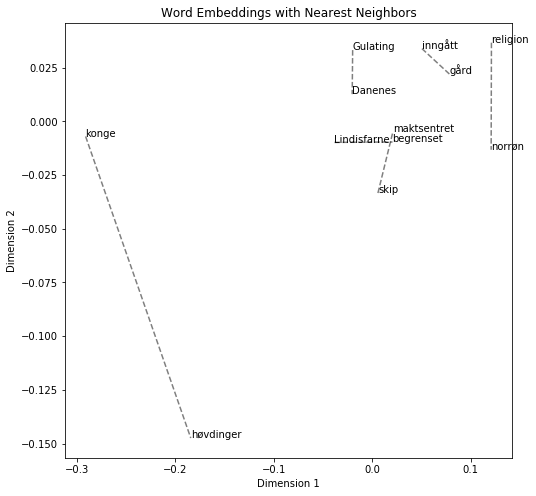

In [113]:
import matplotlib.pyplot as plt
from scipy.spatial import distance

def plot_word_embeddings3(word_embeddings, words):
    fig, ax = plt.subplots(figsize=(8, 8))
#simple plotting function to visualize the semantic space with the use of nearest neighbor
    # Plot the specified words and annotate them
    for word in words:
        embedding = word_embeddings.get(word)
        if embedding is not None:
            ax.annotate(word, (embedding[0], embedding[1]))

    # Find and plot nearest neighbors for each specified word
    for word in words:
        embedding = word_embeddings.get(word)
        if embedding is not None:
            distances = [(w, distance.euclidean(embedding, emb)) for w, emb in word_embeddings.items() if w != word]
            nearest_neighbors = sorted(distances, key=lambda x: x[1])[:1]  # Change 3 to the desired number of neighbors

            for neighbor, _ in nearest_neighbors:
                neighbor_embedding = word_embeddings.get(neighbor)
                if neighbor_embedding is not None:
                    ax.plot([embedding[0], neighbor_embedding[0]], [embedding[1], neighbor_embedding[1]], 'k--', alpha=0.5)
                    ax.annotate(neighbor, (neighbor_embedding[0], neighbor_embedding[1]))

    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.title("Word Embeddings with Nearest Neighbors")
    plt.savefig('GloVe_NN_plot.png')
    plt.show()
    
words_to_plot2 = ['konge', 'gård', 'skip','religion','Lindisfarne', 'Gulating',]
plot_word_embeddings3(word_embeddings_viking, words_to_plot2)

## Distance between words

In [115]:
import pandas as pd
from scipy.spatial import distance

def find_closest_words(word_embeddings, target_word):
    distances = [(word, distance.euclidean(embedding, word_embeddings[target_word])) for word, embedding in word_embeddings.items()]
    sorted_distances = sorted(distances, key=lambda x: x[1])[1:6]  # Exclude the target word itself and select the five closest words

    word_list = [pair[0] for pair in sorted_distances]
    distance_list = [pair[1] for pair in sorted_distances]

    df = pd.DataFrame({'Word': word_list, 'Distance': distance_list})
    df.index = range(1, len(df) + 1)  # Set the index starting from 1

    return df

target_word = 'Sverige' #here you choose the desired target word
closest_words_table = find_closest_words(word_embeddings_viking, target_word)
print(closest_words_table)



         Word  Distance
1       liten  0.414556
2       gifte  0.417302
3         enn  0.417847
4      Norden  0.424852
5  samfunnet,  0.430038


Due to a lack of a small corpus the results here are not to satisfying, using a bigger orpus would yield better results.